In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls drive/My\ Drive/proyecto_patrones/

denoised_testing   MetaData.npy    testing	      training_split.zip
denoised_training  proyecto.ipynb  testing_split.zip  Untitled0.ipynb
MetaData.mat	   readme.txt	   training


In [0]:
!unzip drive/My\ Drive/proyecto_patrones/training_split

In [0]:
!pip3 install pybalu

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Input, Dropout, Flatten, BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from pybalu.feature_transformation import pca, normalize
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import MinMaxScaler

import os
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

Using TensorFlow backend.


# Data

In [0]:
def load_data(path, imgs):
  data = []
  for img in imgs:
    img_loaded = cv2.imread(path + '/' + img)
    img_loaded = cv2.resize(img_loaded, (224, 224))
    data.append(img_loaded)
  data = np.array(data)
  return data




def flip_img(imgs):
  flipped = []
  for img in imgs:
    flipped.append(img[:, ::-1])
  flipped = np.array(flipped)
  
  return np.vstack((imgs, flipped))

In [0]:
def build_dataset(pos_X, neg_X):
  pos_neg_X = np.vstack((pos_X, neg_X))
  X = []
  for img in range(0, len(pos_neg_X), 2):
    X.append(np.array([pos_neg_X[img], pos_neg_X[img + 1]]))
  X = np.array(X)
  return X

def extract_features(X, model):
  old = X[:, 0, :, :]
  new = X[:, 1, :, :]

  features_old = model.predict(old, verbose=1, batch_size=256)
  features_new = model.predict(new, verbose=1, batch_size=256)
  
  return features_old, features_new

def pca_transform(features_new, features_old):
  X_new_pca, _, A_new, Xm_new, _ = pca(features_new, n_components=10)
  X_old_pca, _, A_old, Xm_old, _ = pca(features_old, n_components=10)
  
  return X_new_pca, A_new, Xm_new, X_old_pca, A_old, Xm_old

In [0]:
pos_imgs = os.listdir('training_split/pos')
pos_imgs.sort()

neg_imgs = os.listdir('training_split/neg')
neg_imgs.sort()

pos_X = load_data('training_split/pos', pos_imgs)
neg_X = load_data('training_split/neg', neg_imgs)


y_pos = np.array([1] * (pos_X.shape[0]))
y_neg = np.array([0] * (neg_X.shape[0]))

In [0]:
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(pos_X, y_pos, test_size=0.1, shuffle=True)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = train_test_split(neg_X, y_neg, test_size=0.1, shuffle=True)

In [0]:
X_train_pos = flip_img(X_train_pos)
X_train_neg = flip_img(X_train_neg)

In [8]:
X_train = build_dataset(X_train_pos, X_train_neg)
X_val = build_dataset(X_val_pos, X_val_neg)

X_train.shape, X_val.shape

((6300, 2, 224, 224, 3), (350, 2, 224, 224, 3))

# Feature

In [9]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-c1l6dmwg
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-c1l6dmwg
  Stored in directory: /tmp/pip-ephem-wheel-cache-5y5mkfo7/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [10]:
from keras_vggface.vggface import VGGFace

layer_name_vggface = 'fc7'

vgg_model = VGGFace(input_shape=(224, 224, 3))
out = vgg_model.get_layer(layer_name_vggface).output
vgg_model_new = Model(vgg_model.input, out)

W0618 04:42:50.461607 139622190286720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 04:42:50.475412 139622190286720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 04:42:50.480860 139622190286720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 04:42:50.507045 139622190286720 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0618 04:42:51.281311 139622190286720 deprecation_wrapp

In [0]:
layer_name_model = 'fc2'

model = VGG16(weights='imagenet', include_top=True)
out = model.get_layer(layer_name_model).output
model_new = Model(model.input, out)

In [0]:
X_new_features_train, X_old_features_train = extract_features(X_train, vgg_model_new)
X_new_pca_train, A_new, Xm_new, X_old_pca_train, A_old, Xm_old = pca_transform(X_new_features_train, X_old_features_train)

In [0]:
X_new_features_val, X_old_features_val = extract_features(X_val, vgg_model_new)

X_new_pca_val = np.matmul(X_new_features_val - Xm_new, A_new)
X_old_pca_val = np.matmul(X_old_features_val - Xm_old, A_old)

In [0]:
X_features_train = np.hstack((X_new_pca_train, X_old_pca_train))
X_features_val = np.hstack((X_new_pca_val, X_old_pca_val))

X_features_train.shape, X_features_val.shape

In [0]:
y_train = np.array([1] * (X_features_train.shape[0] // 2) + [0] * (X_features_train.shape[0] // 2))
y_val = np.array([1] * (X_features_val.shape[0] // 2) + [0] * (X_features_val.shape[0] // 2))
y_train.shape,  y_val.shape

# Model

In [17]:
#clf = SVC(gamma='auto')
clf = MLPClassifier(hidden_layer_sizes=(100, 50))
clf.fit(X_features_train, y_train) 

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [18]:
clf.score(X_features_val, y_val)

0.46

In [19]:
y_pred = clf.predict(X_features_val)
y_true = y_val

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.47      0.57      0.51       175
           1       0.45      0.35      0.39       175

    accuracy                           0.46       350
   macro avg       0.46      0.46      0.45       350
weighted avg       0.46      0.46      0.45       350



# Test

In [0]:
!unzip drive/My\ Drive/proyecto_patrones/testing_split.zip

In [0]:
pos_imgs = os.listdir('testing_split/pos')
pos_imgs.sort()

neg_imgs = os.listdir('testing_split/neg')
neg_imgs.sort()

pos_X = load_data('testing_split/pos', pos_imgs)
neg_X = load_data('testing_split/neg', neg_imgs)

In [14]:
X_test = build_dataset(pos_X, neg_X)
X_test.shape

(944, 2, 224, 224, 3)

In [15]:
X_new_features_test, X_old_features_test = extract_features(X_test, vgg_model_new)

#X_new_pca_test = np.matmul(X_new_features_test - Xm_new, A_new)
#X_old_pca_test = np.matmul(X_old_features_test - Xm_old, A_old)

944/944 [==============================] - 4s 5ms/step


In [0]:
def get_matrix(X_new, X_old, estimator):
    matrix = np.zeros((X_new.shape[0], X_old.shape[0]))
    for i in range(X_new.shape[0]):
        for j in range(X_old.shape[0]):
            matrix[i][j] = np.array([estimator.predict_proba(np.concatenate([X_new[i], X_old[j]]).reshape(1, -1))[0][1]]).reshape(1, -1)
    return matrix

In [0]:
from sklearn.preprocessing import normalize


X_new_features_test_pos = X_new_features_test[:X_new_features_test.shape[0]//2]
X_old_features_test_pos = X_old_features_test[:X_old_features_test.shape[0]//2]

X_old_norm = normalize(X_old_features_test_pos, norm='l1', axis=1, copy=True, return_norm=False)
X_new_norm = normalize(X_new_features_test_pos, norm='l1', axis=1, copy=True, return_norm=False)

In [0]:
from sklearn.metrics.pairwise import cosine_similarity

SS = cosine_similarity(X_old_norm, X_new_norm)

In [19]:
diagonal = SS.diagonal()
non_diagonal = SS[np.where(~np.eye(SS.shape[0],dtype=bool))]

diagonal.shape, non_diagonal.shape

((472,), (222312,))

In [20]:
import math

mu_1, sigma_1 = np.mean(diagonal), np.std(diagonal)
mu_2, sigma_2 = np.mean(non_diagonal), np.std(non_diagonal)

d = math.fabs(mu_2 - mu_1) / math.sqrt((sigma_1**2 + sigma_2**2) / 2)
d

1.6386385113671909

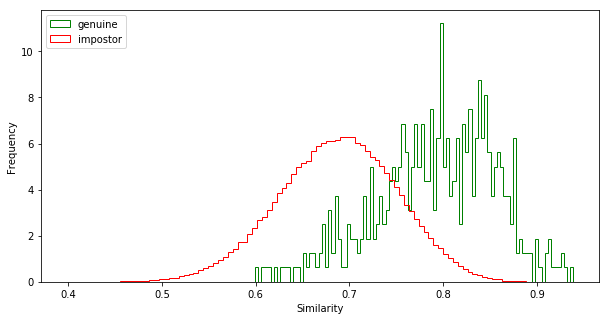

In [21]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,5))
plt.hist(diagonal, 100, label='genuine', histtype='step', density=True, color='green', stacked=True)
plt.hist(non_diagonal, 100, label='impostor', histtype='step', density=True, color='red', stacked=True)
plt.legend()
plt.xlabel('Similarity')
plt.ylabel('Frequency')
plt.savefig('feats_ignacio.png', dpi=300, pad_inches=0.1, bbox_inches='tight')
plt.show()

### Modelo

In [0]:
def cos_model(X_old_norm, X_new_norm):
    pred = []
    for i in range(X_old_norm.shape[0]):
        pred.append( cosine_similarity(np.array([X_old_norm[i], X_new_norm[i]]))[0][1] )
    pred = np.array(pred)
    
    pred[pred >= 0.75] = 1
    pred[pred < 0.75] = 0
    return pred

In [0]:
y_pred = cos_model(X_new_features_test, X_old_features_test)

In [33]:
y_test = np.array([1] * 472 + [0] * 472 )
y_test.shape

(944,)

In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       472
           1       0.82      0.76      0.79       472

    accuracy                           0.79       944
   macro avg       0.80      0.79      0.79       944
weighted avg       0.80      0.79      0.79       944



In [0]:
np.save('new_features_test.npy', X_new_features_test)
np.save('old_features_test.npy', X_old_features_test)

In [0]:
X_features_test = np.hstack((X_new_pca_test, X_old_pca_test))
X_features_test.shape

(944, 20)

In [0]:
y_test = np.array([1] * (X_features_test.shape[0] // 2) + [0] * (X_features_test.shape[0] // 2))
y_test.shape

(944,)

In [0]:
clf.score(X_features_test, y_test)

0.5095338983050848

In [0]:
y_pred = clf.predict(X_features_test)
y_true = y_test

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.51      0.57      0.54       472
           1       0.51      0.45      0.48       472

    accuracy                           0.51       944
   macro avg       0.51      0.51      0.51       944
weighted avg       0.51      0.51      0.51       944

